<a href="https://colab.research.google.com/github/jbadham/Coursera_Capstone/blob/master/City_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Identification with Venue Descriptions

Created by Jennifer Badham for the IBM Professional Certificate in Data Science  
March 2020  

## Introduction

The current Covid-19 pandemic demonstrates that the world is interconnected, as it moves from Asia, to Europe and then to North America, with further spread expected. Such connectivity reflects a deeper globalisation whereby cultural products such as blues music and K-pop are popular worldwide, and multinational corporations such as Amazon and Samsung operate on a global scale.

Such movements of people, goods, and practices has led to a blurring of cultural differences where, for example, Starbucks competes against cafes in Paris but not in Rome. More generally, Italian and Chinese restaurants are popular in major cities throughout the world.

This report examines the extent to which types of venues can be used to distinguish between three cities with approximately 10 million residents - New York (USA), Tokyo (Japan) and Paris (France). These cities are the largest in their nations, appear near the top of various lists of global cities and are located in different continents. With their international orientation, if these cities can be separated, then that is strong evidence that significant cultural differences remain.

Note that this is intended as a social sciences research question, not a business problem. A decision tree is used for classification because it focusses on the specific features (venue types) of the neighbourhood to distinguish between cities. This approach relates directly to the research question about whether the cities can be distinguished and identifies the key venue types that differ between cities. That is, the results will identify the ways in which different cultures are reflected in the types of goods that people buy, and services and public attractions that are available. This is an important topic in cultural sociology.

## Data

The key data to inform this research are the types of venues located in the central area of the city. Venues include retailers such as restaurants or fashion shops, service providers such as banks, and public facilities such as parks or art galleries.

Multiple neighbourhoods are to be examined for each city. For each neighbourhood, the most popular 100 venues are to be obtained from the dataset underpinning the Foursquare City Guide local search and venue recommender app.

Foursquare includes the type of venue (referred to as category) for each venue in its dataset. In this study, I will identify the most popular categories for all cities combined and use these to construct a profile for each neighbourhood. That profile will report the proportion of the top 100 venues in the neighbourhood in each of the relevant categories. For example, what proportion are restaurants or parks.

The neighbourhood profiles will be used to construct a decision tree that classifies each neighbourhood to its city. Japanese, American and French restaurants will be excluded from the profiles so that the classification is not biased by the availability of local cuisine.

## Methods

There are two major steps, constructing venue profiles and using those profiles to classify cities. The latitude and longitude for each neighbourhood in the metropolitan area of the three cities is used to centre searches to Foursquare to retrieve the details of venues in each neighbourhood. After removing the local cuisine restaurants, the profiles are constructed as the proportion of venues in each of the most popular categories. A decision tree is constructed on a sample of neighbourhoods and tested on the remaining neighbourhoods.


In [0]:
# preparation - load libraries
import pandas as pd
import numpy as np

**Step 1: Obtain latitude and longitude for neighbourhoods**

The Foursquare API requires latitude and longitude to centre the venue search. Therefore, the latitude and longitude of each neighbourhood in the three cities is required.

Paris has 20 administrative areas in the metropolitan area, with postal codes 75000 to 75020. For Tokyo, the 23 wards of the metropolitan area have postal codes with the first three digits in the range 100 to 179 and names that end in 'ku'. New York has 42 well defined administrative regions, but several postal codes are included within each. For New York, I used the first postal code in the list at https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

Due to previous problems with the Python geocoding package, I supplied this postal code (Paris, New York) or ward name (Tokyo) information to the batch geocode tool at https://geocode.localfocus.nl/, restricted to the relevant country. That provided a text format latitude and longitude for each location, which I used to construct a csv file of neighbourhoods and locations.


In [2]:
locations = pd.read_csv("https://raw.githubusercontent.com/jbadham/Coursera_Capstone/master/CityLocations.csv")
locations.head(3)

,City,Neighbourhood,Latitude,Longitude
0,Paris,75001,48.862630,2.336293
1,Paris,75002,48.867903,2.344107
2,Paris,75003,48.863054,2.359361


**Step 2: Construct neighbourhood profiles using Foursquare venue data**

Foursquare data is used to extract up to 100 venues for each neighbourhood. The neighbourhood profile describes the proportion of venues in the neighbourhood that fall into each of the most common venue categories overall.

Retrieve the neighbourhood information from Foursquare.

In [3]:
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# set up Foursquare credentials
CLIENT_ID = 'CEWHNCOSODH3US5NVLI5H2ZKJN5FWHPEQS4BBJSRSUIKNIS1' # your Foursquare ID
CLIENT_SECRET = 'EAINZEE4FJBAUS5XLOHW0JQLC1RO0LBWOUHUKVKFT21MVVFN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# define function to return venue name and category
radius = 500   # within 500m of specified location
LIMIT = 100    # up to 100 venues

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    # construct the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Category']
    
    return(nearby_venues)

# return the venue details for all Toronto neighbourhoods
venues = getNearbyVenues(names = locations['Neighbourhood'],
                            latitudes = locations['Latitude'],
                            longitudes = locations['Longitude']
                            )

venues

,Neighbourhood,Latitude,Longitude,Venue,Category
0,75001,48.862630,2.336293,Musée du Louvre,Art Museum
1,75001,48.862630,2.336293,Palais Royal,Historic Site
2,75001,48.862630,2.336293,Comédie-Française,Theater
3,75001,48.862630,2.336293,Cour Napoléon,Plaza
4,75001,48.862630,2.336293,Place du Palais Royal,Plaza
...,...,...,...,...,...
4178,10301,40.627505,-74.094377,Silver Lake Park Dog Run,Dog Run
4179,10314,40.599263,-74.165748,Chock Full Of Nuts,Coffee Shop
4180,10314,40.599263,-74.165748,1001 Nights Cafe,Hookah Bar
4181,10314,40.599263,-74.165748,Arabian Nights Restaurant and Hookah Lounge,Hookah Bar


Identify the most popular venue categories (combining the cities) and report the top 30.

In [4]:
num_categories = venues.groupby('Category').count()
num_categories.drop(['Neighbourhood', 'Latitude', 'Longitude'], axis = 'columns', inplace=True)
num_categories.sort_values('Venue', ascending=False, inplace=True)
num_categories.head(30)

,Venue
Category,
French Restaurant,184
Convenience Store,140
Coffee Shop,131
Italian Restaurant,129
Café,122
Hotel,119
Pizza Place,106
Bakery,99
Japanese Restaurant,93


Remove the local cuisine for all cities, including the local cuisine of each other. However, as the neighbourhood style is relevant, these are all reclassified generically as 'Restaurant' (and 'Bar' for Sake bars), and most common categories rechecked.

In [5]:
# replace local cuisine with generic restaurant
venues.Category.replace("French Restaurant", "Restaurant", inplace=True)
venues.Category.replace("Japanese Restaurant", "Restaurant", inplace=True)
venues.Category.replace("Ramen Restaurant", "Restaurant", inplace=True)
venues.Category.replace("Sushi Restaurant", "Restaurant", inplace=True)
venues.Category.replace("American Restaurant", "Restaurant", inplace=True)
venues.Category.replace("Sake Bar", "Bar", inplace=True)

# check the most popular venue categories
num_categories = venues.groupby('Category').count()
num_categories.drop(['Neighbourhood', 'Latitude', 'Longitude'], axis = 'columns', inplace=True)
num_categories.sort_values('Venue', ascending=False, inplace=True)
num_categories.head(25)

,Venue
Category,
Restaurant,483
Convenience Store,140
Coffee Shop,131
Italian Restaurant,129
Café,122
Bar,120
Hotel,119
Pizza Place,106
Bakery,99


Retain only the venues that are in one of these most common 20 categories.

In [6]:
# store the relevant categories
top_categories = num_categories[0:20]
top_categories.reset_index(inplace=True)
print("Total venues expected in top 20 categories:", top_categories['Venue'].sum())

# count venues by category in each neighbourhood
cat_counts = venues.groupby(by = ['Neighbourhood', 'Category']).count()
cat_counts.drop(['Latitude', 'Longitude'], axis='columns', inplace=True)
cat_counts.reset_index(inplace=True)

# drop the less common categories
cat_counts_clean = cat_counts[cat_counts['Category'].isin(top_categories['Category'])]
print("Confirm filtered correctly:", cat_counts_clean['Venue'].sum())

Total venues expected in top 20 categories: 2029
Confirm filtered correctly: 2029


Restricting to the most frequent 20 categories reduced the total number of venues found from over 4000 to around 2000 (exact numbers depend on when the report is run as the Foursquare data is constantly being revised).

Construct a profile for each neighbouhood that contains the proportion of returned venues that are of each of these top 20 categories.

In [7]:
# calculate the total number of venues in each neighbourhood (restricted to top 20 categories)
nbr_totals = cat_counts_clean.groupby('Neighbourhood')['Venue'].sum()

# merge the total onto the cleaned category counts and calculate proportions
profiles = cat_counts_clean.merge(nbr_totals, left_on = 'Neighbourhood', right_index=True)
profiles['Prop'] = profiles['Venue_x'] / profiles['Venue_y']
profiles.drop(['Venue_y'], axis='columns', inplace=True)
profiles.rename(columns={'Venue_x':'Venues'}, inplace=True)

# reshape so that each proportion is a feature
nbr_proportions = profiles.pivot(index='Neighbourhood', columns='Category', values='Prop')
# replace the missing values with 0 
nbr_proportions.fillna(0, inplace=True)

# add the city identifier
nbr_proportions.reset_index(inplace=True)
df_neighbourhoods = locations.merge(nbr_proportions)
df_neighbourhoods.drop(['Latitude', 'Longitude'], axis='columns', inplace=True)

# check reasonable
df_neighbourhoods.head()

,City,Neighbourhood,Bakery,Bar,Bistro,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Convenience Store,Deli / Bodega,Grocery Store,Hotel,Ice Cream Shop,Italian Restaurant,Mexican Restaurant,Park,Pizza Place,Restaurant,Sandwich Place,Supermarket,Wine Bar
0,Paris,75001,0.017857,0.035714,0.035714,0.107143,0.017857,0.017857,0.107143,0.0,0.000000,0.017857,0.125000,0.000000,0.035714,0.000000,0.000000,0.017857,0.410714,0.017857,0.000000,0.035714
1,Paris,75002,0.085106,0.042553,0.063830,0.000000,0.000000,0.127660,0.063830,0.0,0.000000,0.000000,0.063830,0.021277,0.085106,0.042553,0.000000,0.021277,0.276596,0.021277,0.000000,0.085106
2,Paris,75003,0.066667,0.000000,0.066667,0.088889,0.044444,0.066667,0.133333,0.0,0.044444,0.000000,0.000000,0.000000,0.066667,0.000000,0.022222,0.022222,0.244444,0.066667,0.022222,0.044444
3,Paris,75004,0.048780,0.000000,0.024390,0.024390,0.000000,0.024390,0.048780,0.0,0.024390,0.000000,0.097561,0.146341,0.048780,0.000000,0.048780,0.024390,0.365854,0.000000,0.000000,0.073171
4,Paris,75005,0.085106,0.063830,0.021277,0.106383,0.000000,0.000000,0.063830,0.0,0.000000,0.000000,0.148936,0.021277,0.106383,0.021277,0.021277,0.021277,0.276596,0.000000,0.000000,0.042553


**Step 3: Exploratory data analysis**

Examine whether there are apparent differences in the venue category patterns between cities by examining the distribution of proportions within each city.

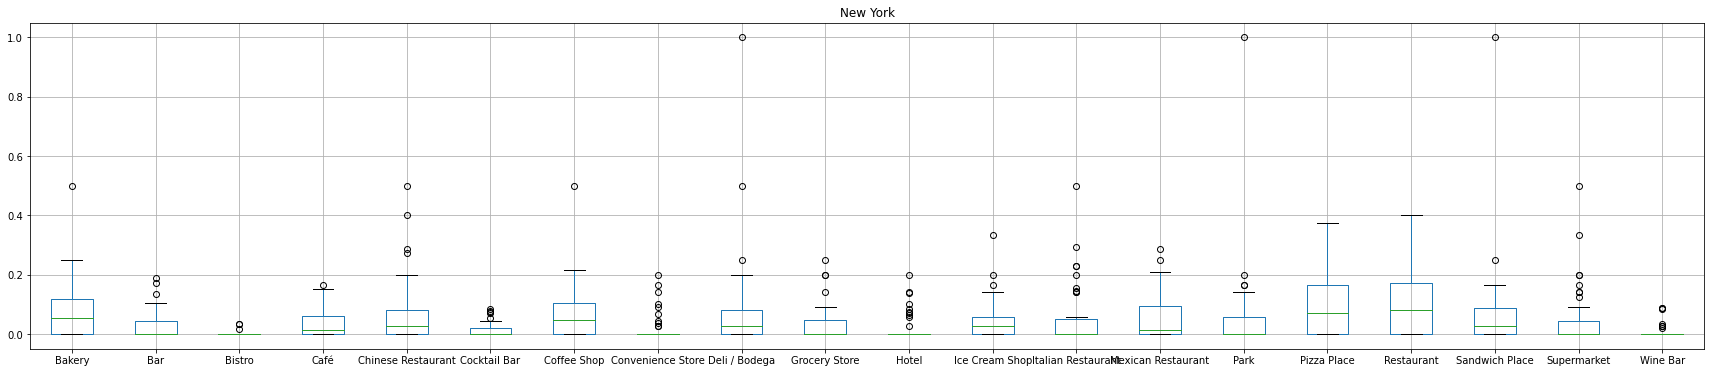

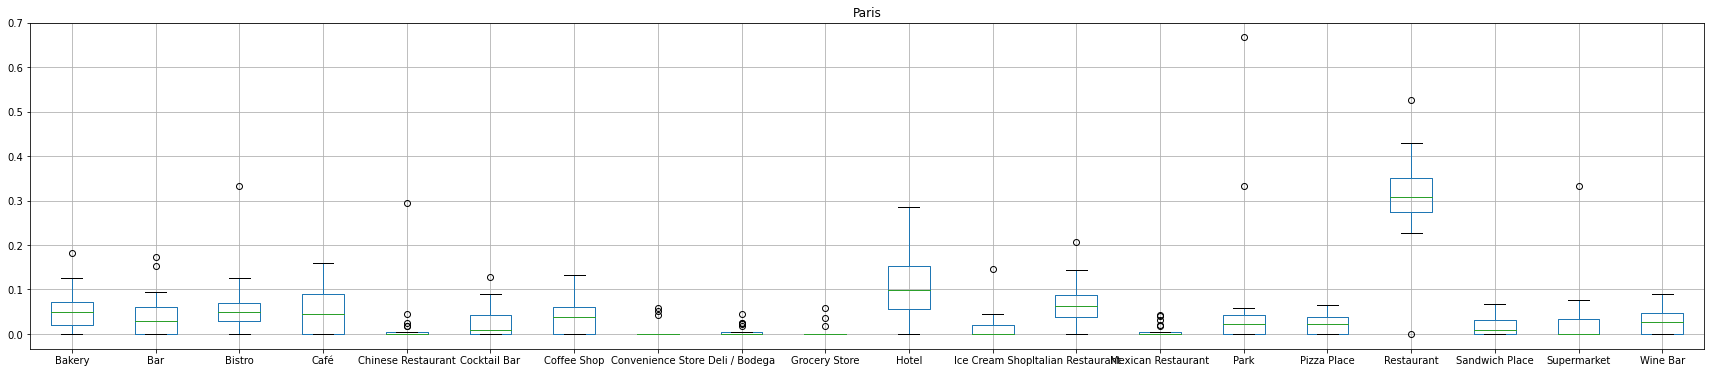

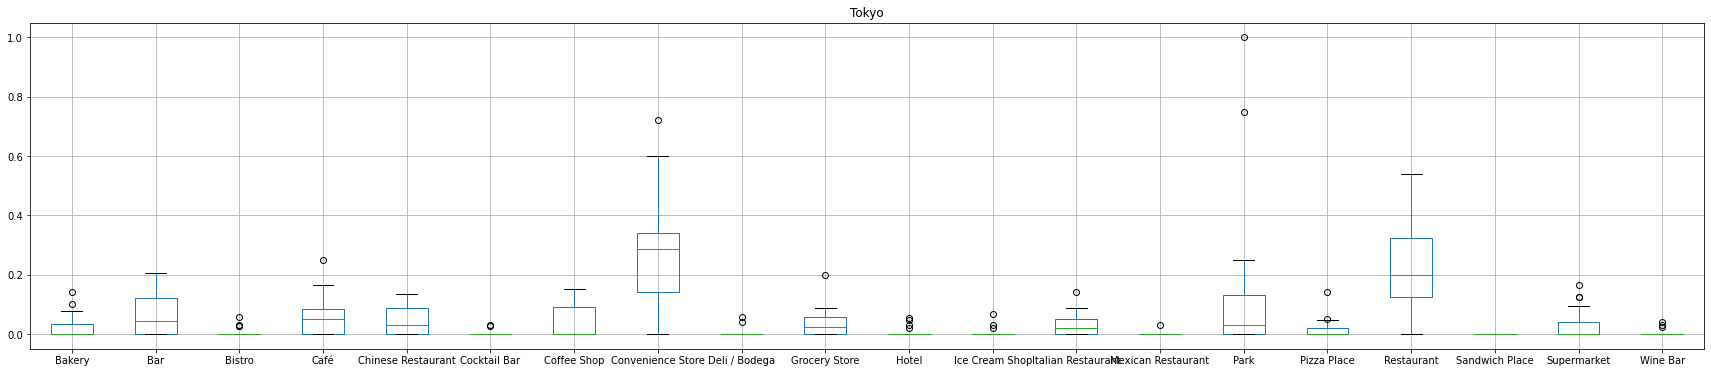

In [8]:
# construct a boxplot over the neighbourhoods in each city, with a separate box for each venue category
import matplotlib.pyplot as plt
prop_cols = df_neighbourhoods.columns.values.tolist()[2:22]

for this_city in ['New York', 'Paris', 'Tokyo']:
  df_plot = df_neighbourhoods[df_neighbourhoods['City'] == this_city]
  plt.figure(figsize=[30,6])
  plt.title(this_city)
  df_plot.boxplot(column=prop_cols)

There are clear differences between the venue categories in each city. For example, 'Deli / Bodega' occurs almost always in New York, and Paris has almost no Chinese Restaurants. This suggests that a decision tree will be able to differentiate between the cities.

**Step 4: Prepare for decision tree**

There are 85 neighbourhoods distributed over three cities and some neighbourhoods have very small numbers of venues and consequently unusual patterns of categories. The neighbourhoods are split into two groups, one for training the decision tree and the other for testing on new data. Due to the small size of the sample, a relatively high proportion (30%) is used for testing.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# split the neighbourhoods into training and test data, array data structures required
features = df_neighbourhoods[prop_cols].values
classes = df_neighbourhoods['City'].values
features_trainset, features_testset, classes_trainset, classes_testset = train_test_split(features, classes, test_size=0.3, random_state=123)

# Results

Construct the decision tree. Depth limit is varied to compare performance with usability. The decision tree correctly classifies (on training data) all neighbourhoods with a depth of 4 to 8 (with different training samples).

In [10]:
# create and fit the decision tree
city_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
city_tree.fit(features_trainset, classes_trainset)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Visualise the decision tree, to see its performance and depth. By inspection, maximum depth of 3 was selected to balance complexity with performance, as this results in some leaves with pure selection for each city and the leaves with mixed cities represent only a small number of neighbourhoods.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


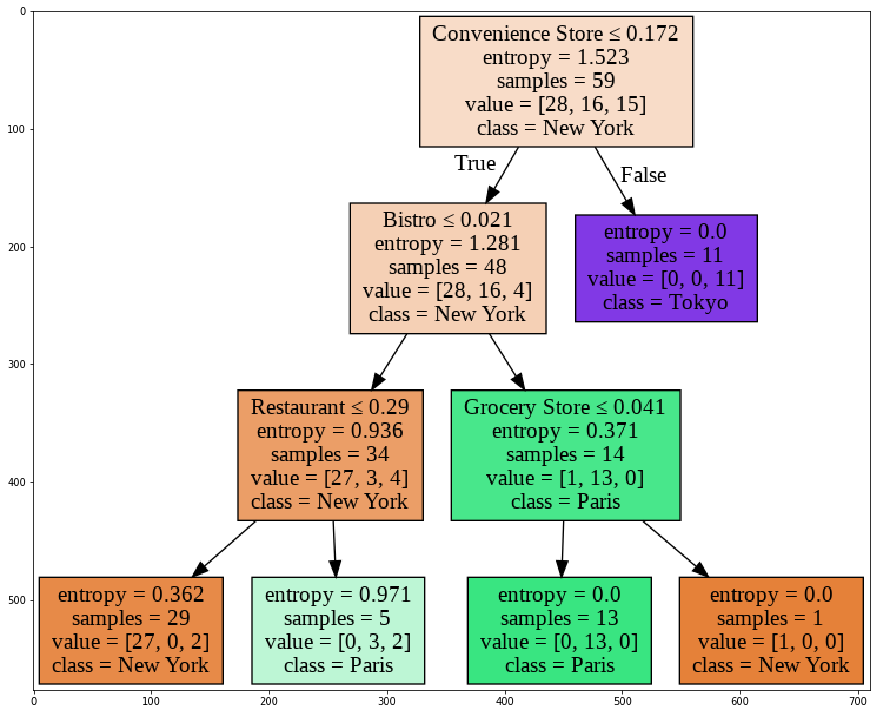

In [11]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

dot_data = StringIO()
filename = "cityDT.png"
out=tree.export_graphviz(city_tree,
                         feature_names=prop_cols,
                         out_file=dot_data,
                         class_names= np.unique(classes_trainset),
                         filled=True, special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(15, 15))
plt.imshow(img,interpolation='nearest')

Measure performance with the testing dataset to estimate performance for novel neighbourhoods.

In [12]:
from sklearn import metrics

# accuracy on training data (for comparison)
train_prediction = city_tree.predict(features_trainset)
print("Decision Tree Accuracy (training data): ", metrics.accuracy_score(classes_trainset, train_prediction))

# accuracy on training data (for comparison)
test_prediction = city_tree.predict(features_testset)
print("Decision Tree Accuracy (test data): ", metrics.accuracy_score(classes_testset, test_prediction))

Decision Tree Accuracy (training data):  0.9322033898305084
Decision Tree Accuracy (test data):  0.8076923076923077


# Discussion

The decision to reduce the number of levels is supported by the performance difference for the samples of neighbourhoods used to train the decision tree and that used to test it. The reduction in accuracy suggests that the tree is partially fitting noise.

With a depth of 3, the decision tree assigns the correct city to 81% of the neighbourhoods in the test data. This suggests that there are meaningful differences between the type of venues described by Foursquare users in the metropolitan areas of three global cities: New York, Tokyo and Paris.

The most important distinguishing feature is the presence of convenience stores. All the neighbourhoods in Tokyo had more convenience stores (at least 17.2% of venues) than any of the metropolitan neighbourhoods in the other cities. Ignoring convenience stores, the path to the largest number of neighbourhoods in Paris follows a relatively high proportion of bistros and a small proportion of deli/bodegas. In contrast, the largest number of neighbourhoods in New York are identified as they have a relatively small proportion of bistros and restaurants.

This suggests future research that examines how convenience stores are used in Japan and what makes them attractive compared to other types of stores. 

# Conclusion

Despite the global movements of people and goods, neighbourhoods retain some local flavour even in the metropolitan areas of some of the most globally oriented cities. Such local flavour is evident in the types of venues that are available. For example, Tokyo is characterised by a high proportion of convenience stores.

Much of the difference between neighbourhoods is expressed through patterns of restaurants and other eating venues. This suggests that eating plays an important part in cultural identity.

-----


# EXAMPLE BLOG

*Nobody really cares about some random data science student who has done a project about venue differences. So I am providing the potential content of a blog below, without actually presenting it as a blog in a public forum.*

There is much talk about the effects of globalisation. It is clear from the Covid-19 pandemic that the world is interconnected. But has the movement of people changed the culture so much that it is no longer obvious where you are?

New York (USA), Paris (France) and Tokyo (Japan) are great cities, regularly appearing high in lits of top global cities (see, for example, https://en.wikipedia.org/wiki/Global_city). If globalisation causes the loss of cultural identity, it would be most obvious in the metropolitan areas of these cities.

One way to investigate this is to look at the types of venues that are present in these metropolitan areas, such as restaurants, fashion houses, banks and museums. I looked at such information about the most popular venues in each of the metropolitan neighbourhoods in these cities. What I found is that cultural identity is alive and well. It is true that restaurants, coffee shops and Italian restaurants are popular everywhere, subtle remineders of cultural differences remain. Tokyo residents use convenience stores, and Parisians frequent bistros.

Maybe these differences reflect the way in which venues are described, rather than what they actually provide. But, either way, there is a difference in the way that people think about the places they go to when they are in New York, Paris or Tokyo. And isn't that what is meant by culture?


